## TP Optimisation II: Méthodes d'optimisation stochastique

### (Rendu: en format ipynb et en html)

### Nom : ZHANI
### Prénom : Reda
### Groupe: B2

## I. Minimisation stochastique d'une fonction déterministe


On s'intéresse au problème $\min f(x) =\max_{i=1\dots m}|a_i^Tx-b_i | = \max_{i=1\dots m} |(Ax-b)_i|.$ 

On suppose que $a_i$ est un vecteur colonne représentant la $i$eme ligne d'une matrice $A$ de taille $m \times n$ ($m=100, n=20$) , et les $b_i$ sont les composantes d'un second membre $b$ de taille $m$, ($1 \le i \le m$), $x$ un vecteur de taille $n$. Ces quantités sont générées une fois pour toutes à partir de distributions Gaussiennes de moyenne nulle et d'écart type identité.

**Question 1 :** Constuire $A$ et $b$. Proposer le calcul d'un sous-gradient en $x$ de $f$. On pourra utiliser la fonction findmax de Julia. 

   => on a $f(x) =|a_{imax}^Tx-b_{imax} |$ donc on a comme valeur de sous-gradient : $signe(a_{imax}^Tx-b_{imax})a_{imax} $

In [ ]:
?findmax

In [174]:
#import Pkg; 
#Pkg.add("JLD")
using JLD
# Construction des données A  et b
m = 100;
n = 20 ; 
A = load("data.jld")["A"]
b = load("data.jld")["b"]

# init x
x = ones(n,1);

# Fonction calculant un sous-gradient en x de f
function subgrad(A,b,x) 
    # Insérer votre code
    f = A*x-b
    (~,imax) = findmax(abs.(f))
    imax = imax[1]
    return sign(f[imax]) * (A[imax,:])
    # Fin insérer code
end

subgrad (generic function with 1 method)

**Question 2 :** Ce problème peut se reformuler comme un problème de programmation linéaire : $$(\mathcal{P}_{lp})\quad \left\{ \begin{array}{c} \min_{(x,R)\in \mathbb{R}^n\times \mathbb{R}} h(x,R)=R\\
s.c. \quad-R*e\leq A*x-b\leq R*e\end{array}\right.$$ avec $e=[1,\cdots,1]^T\in \mathbb{R}^m$. Résoudre le problème $(\mathcal{P}_{lp})$ en utilisant le solveur "GLPK" de la librairie JuMP. Plus d'informations sont disponibles ici :  http://www.juliaopt.org/JuMP.jl/latest/quickstart/

In [150]:
#using Pkg
#Pkg.add("JuMP"); 
#Pkg.add("GLPK")
using JuMP
using GLPK

# Définition du modèle
# Insérer votre code
model = Model(GLPK.Optimizer)
# Fin insérer code

# Définition des variables d'optimisation
# Insérer votre code
@variable(model, x[1:n])
@variable(model, R)
# Fin insérer code

# Définition de la fonctionnelle à minimiser
#Insérer votre code
@objective(model, Min, R)
# Fin insérer code

# Définition des contraintes
# Insérer votre code
for i in 1:m
    @constraint(model, -R <= sum(A[i, j] * x[j] for j in 1:n) - b[i])
    @constraint(model, sum(A[i, j] * x[j] for j in 1:n) - b[i] <= R)
end
# Fin insérer code
        
# Résolution        
# Insérer votre code
optimize!(model)
# Fin insérer code
        
# Résultats à optimalité                
# Insérer votre code
xstar = value.(x)
Rstar = value(R)
# Fin insérer code
println("The function value at the solution is: ",Rstar, " or ",round(findmax(abs.(A*xstar-b))[1], digits=17))


The function value at the solution is: 1.7354496516663769 or 1.7354496516663798


**Affichage attendu**:
```
The function value at the solution is: 1.7354496516663769 or 1.7354496516663798
```

**Question 3 :** Résoudre le problème en utilisant un algorithme de sous-gradient. Dans un premier temps vous utiliserez un sous-gradient exact (Question 1), puis vous introduirez un bruit artificiel qui suit une distribution normale de moyenne nulle et d'écart-type $3 e-1$.

**Question 4 :** Vous afficherez les courbes de convergence de $f_{best}^k-f_{star}$, avec $f_{star}$ obtenue à la Question 1. Donnez la valeur minimale de $f_{best}^k-f_{star}$.

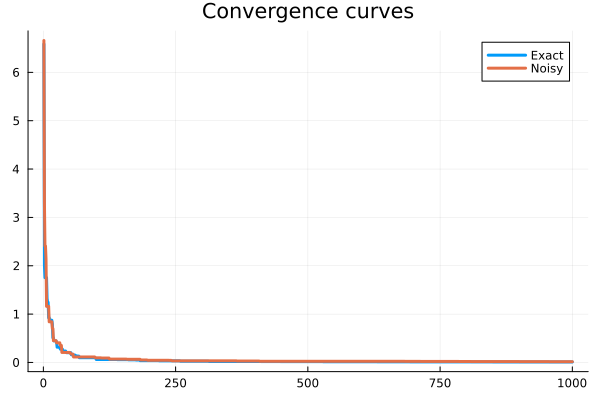

In [152]:
#Pkg.add("Plots")
using Plots

#Initialisation
x = zeros(n,1);
i = 1;
fbest =1e10; # $f_{best}^0$: cas du sous-gradient exact
fbestp=1e10; # $f_{best}^0$: cas du sous-gradient bruité
histo =[];# Suite des itérés f_{best}^k-f_{star} pour le cas du sous-gradient exact
histop=[];# Suite des itérés f_{best}^k-f_{star}, pour le cas du sous-gradient bruité

#Niveau de bruit
noise_lvl=.3;

# Resolution 
# Insérer votre code
itermax=1000;
f_star = findmax(abs.(A*xstar-b))[1]
xp=x;
xp_bruit=x;
while i <= itermax
    #Sans bruit
    alpha = 1/(i+1)
    g=subgrad(A,b,xp)
    xp = xp-alpha*g
    fbest = min(fbest,findmax(abs.(A*xp-b))[1])
    append!( histo, fbest-f_star)
    
    #Avec bruit
    gp=subgrad(A,b,xp_bruit) + noise_lvl*randn(n,1)
    xp_bruit = xp_bruit-alpha*gp
    fbestp = min(fbestp,findmax(abs.(A*xp_bruit-b))[1])
    append!( histop, fbestp-f_star)
    i = i + 1;
end
# Fin insérer code

#Affichage des courbes de convergence
iter=1:itermax;
hf=[histo,histop];
plot(iter,hf,title="Convergence curves",label=["Exact" "Noisy"],lw=3)


In [153]:
println("fbest-f_star = " * string(fbest-f_star))
println("fbestp-f_star = " * string(fbestp-f_star))

fbest-f_star = 0.01028235401650024
fbestp-f_star = 0.016313112389579887


On remarque que les deux courbes sont proches de 0

## II. Minimisation stochastique d'une fonction stochatique



On s'intéresse au problème
$$\min_x f(x) =\text{E} (\max_{i=1\dots m}|a_i^Tx-b_i |).$$

On suppose que $a_i$ est un vecteur colonne représentant la $i$eme ligne d'une matrice $A$ de taille $m \times n$ ($m=100, n=20$) , et les $b_i$ sont les composantes d'un second membre $b$ de taille $m$, ($1 \le i \le m$), $x$ un vecteur de taille $n$. Ces quantités sont générées une fois pour toutes à partir de distributions Gaussiennes de moyenne connue $\bar{A}$ et $\bar{b}$ (non nécesairement nulle) et d'écart type identité.

**Question 5 :** Proposer deux fonctions d'évaluation de la fonction $f$ et d'un sous-gradient de $f$ basées sur des échantillons de taille $M$.


In [154]:
# Evaluation de f
function fvals(Abar,bbar,noise,xs,M) 
    # Abar, bbar : moyenne des données
    # noise : niveau de bruit 
    # xs : vecteur courant 
    # M: taille de l'échantillon

# Insérer votre code
    res = 0
    m,n = size(Abar)
    for i in 1:M 
        A = Abar + (noise * randn(m,n))
        b = bbar + (noise * randn(m,1))
        res += findmax(abs.(A*xs-b))[1]
    end
    return res/M
# Fin insérer code

end

# Evaluation d'un sous-gradient
function subgrads(Abar,bbar,noise,xs,M)
    # Abar, bbar : moyenne des données
    # noise : niveau de bruit
    # xs : vecteur courant
    # M: taille de l'échantillon
    
# Insérer votre code
    m,n = size(Abar)
    res = zeros(n,1)
    for i in 1:M 
        A = Abar + (noise * randn(m,n))
        b = bbar + (noise * randn(m,1))
        res += subgrad(A,b,xs)
    end
    return res/M
# Fin insérer code

end


subgrads (generic function with 1 method)

**Question 6 :** Comparer les courbes de convergence du problème déterministe $$ \min_x f(x) = \max_{i=1\dots m}|\text{E} (a_i)^Tx-\text{E} (b_i) |,$$ et du problème stochastique obtenu avec $M=10,100,1000$ échantillons. Donnez la valeur minimale de $f$.

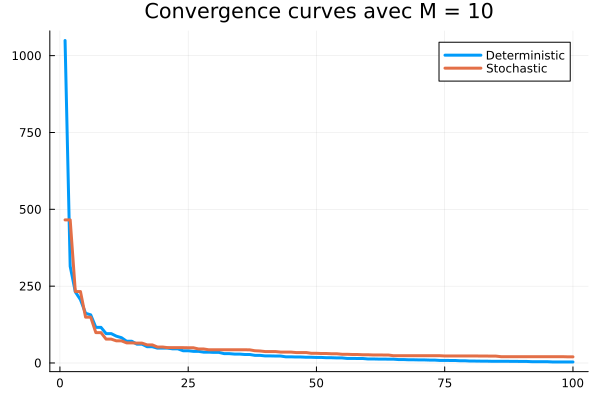

In [158]:
# Données
Abar = load("data2.jld")["Abar"]
bbar = load("data2.jld")["bbar"]

#x_0
xd = zeros(n,1); # problème déterministe
xs = xd; # problème stochastique

# Bruit et echantillon
M  = 10;
noise  = 4;

j = 0;

fbestd =1e10; # $f_{best}^0$: cas d'une résolution déterministe
fbests =1e10; # $f_{best}^0$: cas d'une résolution stochastique
histod =[]; # Suite des itérés f_{best}^k pour le cas d'une résolution déterministe
histos =[]; # Suite des itérés f_{best}^k pour le cas d'une résolution stochastique

# Insérer votre code
itermax=100;
i = 1
while i <= itermax
    # problème déterministe 
    alpha = 1/(i+1)
    g=subgrad(Abar,bbar,xd);
    xd = xd-alpha*g;
    fbestd = min(fbestd,findmax(abs.(Abar*xd-bbar))[1])
    append!( histod, fbestd)

    # problème stochastique 
    g=subgrads(Abar,bbar,noise,xs,M)
    xs = xs-alpha*g;
    f_stoch = fvals(Abar,bbar,noise,xs,M)
    fbests = min(fbests,f_stoch)
    append!( histos, fbests)
    i = i+1
end
# Fin insérer code
#Affichage
iter=1:itermax;
hf=[histod,histos];
plot(iter,hf,title="Convergence curves avec M = "*string(M),label=["Deterministic" "Stochastic"],lw=3)

##### On remarque que avec des valeurs de M plus grandes la courbe devient rapidement lisse

**Question 7 :** Répéter les expériences et comparer les valeurs meilleurs valeurs de f obtenues ($f_{best}$) aprs un nombre fixé d'itérations. Donnez la valeur minimale de $f_{best}$

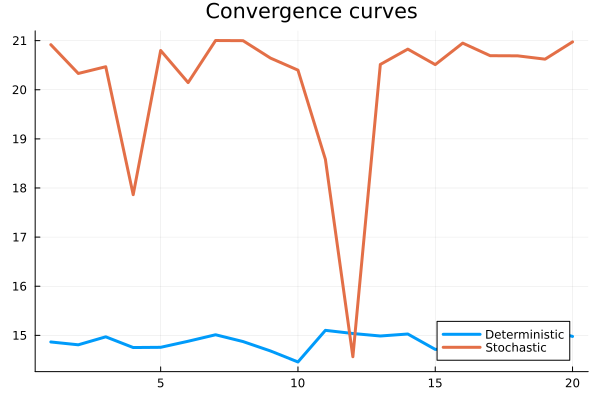

In [172]:
# Données
Abar = load("data2.jld")["Abar"]
bbar = load("data2.jld")["bbar"]

# x_0 
xd = zeros(n,1); # résolution déterministe
xs = xd;  # résolution stochastique

# Bruit et echantillon
M  = 200;
noise  = 4;

#Nombre d'itérations
niter=100;

j = 0;

fbestd =1e10; # $f_{best}^0$: cas d'une résolution déterministe
fbests =1e10; # $f_{best}^0$: cas d'une résolution stochastique
fbesttd=[]; # f_{best} pour chaque expériences dans le cas d'une résolution déterministe
fbestts=[]; # f_{best} pour chaque expériences dans le cas d'une résolution stochastique

for nexp=1:20
    # Répétition des expériences    
# Insérer votre code
    i = 1
    fbestd =1e10; # $f_{best}^0$: cas d'une résolution déterministe
    fbests =1e10; # $f_{best}^0$: cas d'une résolution stochastique
    xd_i = xd
    xs_i = xs
    xbest_deter = xd
    while i <= itermax
        # problème déterministe 
        alpha = 1/(i+1)
        g=subgrad(Abar,bbar,xd_i);
        xd_i = xd_i-alpha*g;
        if findmax(abs.(Abar*xd_i-bbar))[1] < fbestd 
            xbest_deter = xd_i
            fbestd = findmax(abs.(Abar*xd_i-bbar))[1]
        end
        
        #fbestd = min(fbestd,findmax(abs.(Abar*xd_i-bbar))[1])

        # problème stochastique 
        g=subgrads(Abar,bbar,noise,xs_i,M)
        xs_i = xs_i-alpha*g;
        f_stoch = fvals(Abar,bbar,noise,xs_i,M)
        fbests = min(fbests,f_stoch)
        i = i+1
    end
    # Stockage
    fbestd = fvals(Abar,bbar,noise,xbest_deter,M)
    append!( fbesttd, fbestd)
    append!( fbestts, fbests)
# Fin insérer code
end

#Affichage
iter=1:20;
hf=[fbesttd,fbestts];
plot(iter,hf,title="Convergence curves",label=["Deterministic" "Stochastic"],lw=3)